In [1]:
import pickle

system = 'ibmq_mumbai'
N = 4
T = 1
filename = 'circuits/{}_{}_{}.pkl'.format(system,N,T)

with open(filename,'rb') as f:
    circuits = pickle.load(f)

qc = circuits[0]

In [2]:
rx_calibrations = []
rzx_calibrations = []

for a,b in qc.calibrations['rx'].items():
    rx_calibrations.append({"qubit" : [a[0][0]], "calibration": b, "backend" : system})

for a,b in qc.calibrations['rzx'].items():
    rzx_calibrations.append({'qubit':[a[0][0],a[0][1]],"calibration":b, "backend" : system})

In [3]:
rx_calibrations

[{'qubit': [0],
  'calibration': ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.3255700421749741, amp=0.017304260967199902, angle=0), DriveChannel(0)), name="rx(0.333)", transform=AlignLeft()),
  'backend': 'ibmq_mumbai'},
 {'qubit': [3],
  'calibration': ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.8819919706275321, amp=0.01728112981405072, angle=0), DriveChannel(3)), name="rx(0.333)", transform=AlignLeft()),
  'backend': 'ibmq_mumbai'},
 {'qubit': [1],
  'calibration': ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-1.006015825011755, amp=0.01879108024949618, angle=0), DriveChannel(1)), name="rx(0.333)", transform=AlignLeft()),
  'backend': 'ibmq_mumbai'},
 {'qubit': [2],
  'calibration': ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=0.712123099062549, amp=0.01741184793101846, angle=0), DriveChannel(2)), name="rx(0.333)", transform=AlignLeft()),
  'backend': 'ibmq_mumbai'}]

In [4]:
rzx_calibrations

[{'qubit': [3, 2],
  'calibration': ScheduleBlock(ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.19520114753852078, angle=-1.9544697125140549), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.03395294325727564, angle=-0.033645972852721674), DriveChannel(2)), name="rescale_cr_inst", transform=AlignLeft()), name="block1", transform=AlignLeft()), ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.7877311941319368, amp=0.1617184918363154, angle=0.0, name='Xp_d3'), DriveChannel(3), name='Xp_d3'), name="x", transform=AlignLeft()), ScheduleBlock(ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.19520114753852078, angle=1.1871229410757382), ControlChannel(6)), name="rescale_cr_inst", transform=AlignLeft()), ScheduleBlock(Play(GaussianSquare(duration=256, sigma=64, width=0, amp=0.03395294325727564, angle=3.1079466807370713), DriveChanne

In [5]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_provider import IBMProvider
from qiskit_experiments.library import InterleavedRB
from qiskit import QuantumCircuit

In [6]:
provider = IBMProvider()

In [7]:
#Circuit to only pass as a gate
gate_circuit = QuantumCircuit(1, name='custom_rx')
gate_circuit.rx(np.pi/2,0)
custom_rx = gate_circuit.to_gate()

gate_circuit = QuantumCircuit(2, name='custom_rzx')
gate_circuit.rzx(np.pi/2,0,1)
custom_rzx = gate_circuit.to_gate()

backend = provider.get_backend(system)

In [8]:
def add_calibrations(gate,calibrations,backend):

    backend_calibration = {}

    #Create a dictionary like {(config['qubit'][0],): InstructionProperties(calibration=config['calibration'])} from rx_calibrations
    for i in calibrations:
        qubit = i['qubit']
        calibration = i['calibration']
        
        if len(qubit) == 1:
            backend_calibration[(qubit[0],)] = InstructionProperties(calibration=calibration)
        else:
            backend_calibration[(qubit[0],qubit[1])] = InstructionProperties(calibration=calibration)

    #Add the calibration to the backend
    backend.target.add_instruction(gate, backend_calibration)
    return backend

def conduct_interleaved_rb_experiment(gate,qubit,backend):
    
    #Experiment parameters
    lengths = np.arange(1, 200, 30)
    num_samples = 10
    seed = 1010

    if len(qubit) == 1:
        qubits = qubit
    else:
        qubits = (qubit[0],qubit[1])

    int_exp = InterleavedRB(
        gate, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)
    
    int_expdata = int_exp.run(backend).block_for_results()

    return int_expdata
    #return {"qubit": qubits, "backend": backend.name, "job_id": int_expdata.job_ids[0]}

In [9]:
backend.target.add_instruction(custom_rx,{(rx_calibrations[0]['qubit'][0],) : InstructionProperties(calibration=rx_calibrations[0]['calibration'])})

In [9]:
backend = add_calibrations(custom_rx,rx_calibrations,backend)
backend = add_calibrations(custom_rzx,rzx_calibrations,backend)

In [10]:
result = conduct_interleaved_rb_experiment(custom_rx,rx_calibrations[0]['qubit'],backend)

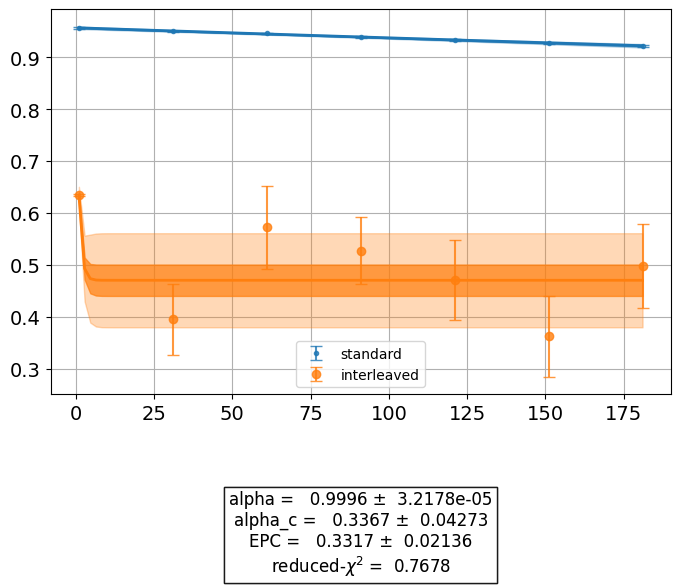

In [11]:
result.figure(0)

In [ ]:
rx_results = list(map(lambda x: conduct_interleaved_rb_experiment(custom_rx,x['qubit'],backend),rx_calibrations))

In [ ]:
rx_results

In [ ]:
rx_filename = 'error_rates/{}_{}_rx_config.pkl'.format(system,T)
rzx_filename = 'error_rates/{}_{}_rzx_config.pkl'.format(system,T)

with open(rx_filename,'wb+') as f:
    pickle.dump(rx_calibrations,f)

with open(rzx_filename,'wb+') as f:
    pickle.dump(rzx_calibrations,f)

Adding data from job failed [Job ID: cq0pc10hbttg008j7tgg]
jobs and analysis raised exceptions [Experiment ID: c178179c-8531-43c8-8ba8-9eedd71eae24]:Traceback (most recent call last):

  File "/Users/amey/anaconda3/envs/simuq/lib/python3.10/site-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(

  File "/Users/amey/anaconda3/envs/simuq/lib/python3.10/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):

  File "/Users/amey/anaconda3/envs/simuq/lib/python3.10/socket.py", line 955, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):

socket.gaierror: [Errno 8] nodename nor servname provided, or not known


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "/Users/amey/anaconda3/envs/simuq/lib/python3.10/site-packages/urllib3/connectionpool.py", li